In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

In [2]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
train_split = 0.8

samples = len(X_train)
split = int(samples * train_split)
X_valid = X_train[split:] / 255.
X_train = X_train[:split] / 255.
y_valid = y_train[split:]
y_train = y_train[:split]

print('No. training examples: %d, No. training labels:%d' % (len(X_train),
                                                             len(y_train)))
print('No. Valid examples: %d, No. Valid labels: %d' % (len(X_valid),
                                                        len(y_valid)))

No. training examples: 48000, No. training labels:48000
No. Valid examples: 12000, No. Valid labels: 12000


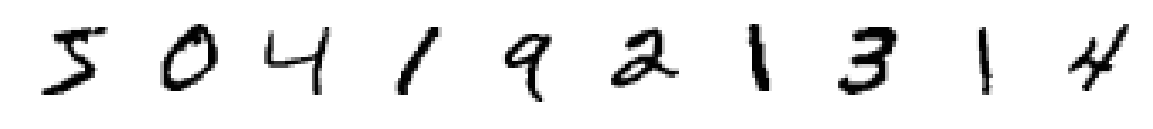

In [5]:
n_samples = 10
plt.figure(figsize=(n_samples * 2, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    sample_image = X_train[i].reshape(28,28)
    plt.imshow(sample_image, cmap='binary')
    plt.axis('off')
    
plt.show()

In [6]:
y_train[:n_samples]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [7]:
#input
X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32, name='X')

In [8]:
#primary capsules
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6
caps1_n_dims = 8

conv1_params = {
    'filters': 256,
    'kernel_size': 9,
    'strides' : 1,
    'padding' : 'Valid',
    'activation': tf.nn.relu
}

conv2_params = {
    'filters': caps1_n_maps * caps1_n_dims,
    'kernel_size': 9,
    'strides' : 2,
    'padding' : 'Valid',
    'activation': tf.nn.relu
}

conv1 = tf.layers.conv2d(X, name='conv1', **conv1_params)
conv2 = tf.layers.conv2d(conv1, name='conv2', **conv2_params)

In [9]:
caps1_raw = tf.reshape(conv2, [-1, caps1_n_caps, caps1_n_dims], name='caps1_raw')

In [10]:
def squash(s, axis=-1, epsilon=1e-7, name=None):
    with tf.name_scope(name, default_name='squash'):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
        safe_norm = tf.sqrt(squared_norm + epsilon)
        squash_factor = squared_norm / (1. + squared_norm)
        unit_vector = s / safe_norm
        return squash_factor * unit_vector

In [11]:
caps1_output = squash(caps1_raw, name='caps1_output')

In [12]:
#Digit capsules
caps2_n_caps = 10
caps2_n_dims = 16

init_sigma = 0.1
W_init = tf.random_normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name = 'W_init')
W = tf.Variable(W_init, name='W')

In [13]:
batch_size = tf.shape(X)[0]
W_tiled = tf.tile(W, [batch_size, 1, 1, 1, 1], name='W_tiled')

In [14]:
caps1_output_expanded = tf.expand_dims(caps1_output, -1,
                                       name='caps1_output_expanded')
caps1_output_tile = tf.expand_dims(caps1_output_expanded, 2,
                                  name='caps1_output_tile')
caps1_output_tiled = tf.tile(caps1_output_tile, [1, 1, caps2_n_caps, 1, 1],
                            name='caps1_output_tiled')

In [15]:
print(W_tiled)
print(caps1_output_tiled)

Tensor("W_tiled:0", shape=(?, 1152, 10, 16, 8), dtype=float32)
Tensor("caps1_output_tiled:0", shape=(?, 1152, 10, 8, 1), dtype=float32)


In [16]:
caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled,
                           name='caps2_predicted')
print(caps2_predicted)

Tensor("caps2_predicted:0", shape=(?, 1152, 10, 16, 1), dtype=float32)


In [17]:
#round 1 routing

raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32, name='raw_weights')
routing_weights = tf.nn.softmax(raw_weights, axis=2, name='routing_weights')

In [18]:
weighted_predictions = tf.multiply(routing_weights, caps2_predicted,
                                  name='weighted_predictions')
weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True,
                            name='weightd_sum')

In [19]:
caps2_output_round1 = squash(weighted_sum, axis=2, name='caps2_output_round1')
print(caps2_output_round1)

Tensor("caps2_output_round1/mul:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [20]:
#round 2 routing
print(caps2_predicted)
print(caps2_output_round1)

Tensor("caps2_predicted:0", shape=(?, 1152, 10, 16, 1), dtype=float32)
Tensor("caps2_output_round1/mul:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [21]:
caps2_output_round1_tiled = tf.tile(
    caps2_output_round1, [1, caps1_n_caps, 1, 1, 1],
    name='caps2_output_round1_tiled')

In [22]:
agreement = tf.matmul(caps2_predicted, caps2_output_round1_tiled,
                     transpose_a=True, name='agreement')
raw_weights_round2 = tf.add(raw_weights, agreement, name='raw_weights_round2')

In [23]:
routing_weights_round2 = tf.nn.softmax(raw_weights_round2, 
                                       axis=2,
                                       name='routing_weights_round2')
weighted_predictions_round2 = tf.multiply(routing_weights_round2,
                                         caps2_predicted,
                                         name='weighted_predictions_round2')
weighted_sum_round2 = tf.reduce_sum(weighted_predictions_round2,
                                    axis=1,
                                    keepdims=True,
                                    name='weighted_sum_round2')
caps2_output_round2 = squash(weighted_sum_round2,
                            axis=2,
                            name='caps2_output_round2')
caps2_output = caps2_output_round2

In [24]:
#class probs
def safe_norm(s, axis=1, epsilon=1e-7, keep_dims=False, name=None):
    with tf.name_scope(name, default_name='safe_norm'):
        squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=keep_dims)
        return tf.sqrt(squared_norm + epsilon)

In [25]:
y_prob = safe_norm(caps2_output, axis=-2, name='y_prob')
y_prob_argmax = tf.argmax(y_prob, axis=2, name='y_prob')
print(y_prob_argmax)

Tensor("y_prob_1:0", shape=(?, 1, 1), dtype=int64)


In [26]:
y_pred = tf.squeeze(y_prob_argmax, axis=[1,2], name='y_pred')
print(y_pred)

Tensor("y_pred:0", shape=(?,), dtype=int64)


In [27]:
#labels
y = tf.placeholder(shape=[None], dtype=tf.int64, name='y')

#margin loss
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

T = tf.one_hot(y, depth=caps2_n_caps, name='T')

with tf.Session():
    print(T.eval(feed_dict={y: np.array([0,1,2,3,4,5])}))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [28]:
print(caps2_output)

Tensor("caps2_output_round2/mul:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [29]:
caps2_output_norm = safe_norm(caps2_output, axis=-2, keep_dims=True,
                              name='caps2_output_norm')

In [30]:
present_error_raw = tf.square(tf.maximum(0., m_plus - caps2_output_norm),
                             name='present_error_raw')
present_error = tf.reshape(present_error_raw, shape=(-1, 10),
                          name='present_error')

absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm - m_minus),
                            name='absent_error_raw')
absent_error = tf.reshape(absent_error_raw, shape=(-1, 10),
                         name='absent_error_raw')

In [31]:
#computing loss
L = tf.add(T * present_error, lambda_ * (1.0 - T) * absent_error, name='L')
margin_loss = tf.reduce_mean(tf.reduce_sum(L, axis=1), name='margin_loss')

In [32]:
#reconstruction
mask_with_labels = tf.placeholder_with_default(False, shape=(),
                                              name='mask_with_labels')
reconst_targets = tf.cond(mask_with_labels,
                         lambda: y,
                         lambda: y_pred,
                         name='reconst_targets')
reconst_mask = tf.one_hot(reconst_targets,
                         depth=caps2_n_caps,
                         name='reconst_mask')
print(reconst_mask)
print(caps2_output)

Tensor("reconst_mask:0", shape=(?, 10), dtype=float32)
Tensor("caps2_output_round2/mul:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [33]:
reconst_mask_reshape = tf.reshape(reconst_mask, [-1, 1, caps2_n_caps, 1, 1],
                                  name='reconst_mask_reshape')
print(reconst_mask_reshape)

Tensor("reconst_mask_reshape:0", shape=(?, 1, 10, 1, 1), dtype=float32)


In [34]:
caps2_output_masked = tf.multiply(caps2_output, reconst_mask_reshape,
                                 name='caps2_output_masked')
print(caps2_output_masked)

Tensor("caps2_output_masked:0", shape=(?, 1, 10, 16, 1), dtype=float32)


In [35]:
decoder_input = tf.reshape(caps2_output_masked, [-1, caps2_n_caps * caps2_n_dims],
                          name='decoder_input')
print(decoder_input)

Tensor("decoder_input:0", shape=(?, 160), dtype=float32)


In [36]:
#decoder
n_hidden1 = 512
n_hidden2 = 1024
n_output = 28 * 28

In [37]:
with tf.name_scope('decoder'):
    hidden1 = tf.layers.dense(decoder_input, n_hidden1,
                             activation=tf.nn.relu,
                             name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2,
                              activation=tf.nn.relu,
                              name='hidden2')
    decoder_output = tf.layers.dense(hidden2, n_output,
                                    activation=tf.nn.sigmoid,
                                    name='decoder_output')

In [38]:
#reconstruction loss
X_flat = tf.reshape(X, [-1, n_output], name='X_flat')
square_diff = tf.square(X_flat - decoder_output, name='square_diff')
reconst_loss = tf.reduce_mean(square_diff, name='reconst_loss')

In [39]:
#totaL loss
alpha = 0.0005
loss = tf.add(margin_loss, alpha * reconst_loss, name='loss')

In [40]:
#accuracy
correct = tf.equal(y, y_pred, name='correct')
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

#training Ops
optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss, name='training_op')

#init and saver
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [41]:
def get_next_batch(batch_size, X, y):
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        yield X[start:end], y[start:end]

In [42]:
#training
epochs = 10
batch_size = 64
restore_checkpoint = False


n_iter_per_epoch = len(X_train) // batch_size
n_iter_per_val = len(X_valid) // batch_size
best_loss_val = np.infty
checkpoint_path = './capsnetv1'

with tf.Session() as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
    
    for e in range(epochs):
        for i, (X_batch, y_batch) in enumerate(get_next_batch(batch_size, X_train, y_train)):
            _, loss_train = sess.run(
                [training_op, loss],
                feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                             y : y_batch,
                             mask_with_labels: True})
            print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      i, n_iter_per_epoch,
                      i * 100 / n_iter_per_epoch,
                      loss_train),
                      end="")
            
        loss_vals = []
        acc_vals = []
        for i, (X_batch, y_batch) in enumerate(get_next_batch(batch_size, X_valid, y_valid)):
            loss_val, acc_val = sess.run(
                [loss, accuracy],
                feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                             y : y_batch})
            loss_vals.append(loss_val)
            acc_vals.append(acc_val)
            loss_val = np.mean(loss_vals)
            acc_val = np.mean(acc_vals)
            print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
                e + 1, acc_val * 100, loss_val,
                " (improved)" if loss_val < best_loss_val else ""))
            
            if loss_val < best_loss_val:
                save_path = saver.save(sess, checkpoint_path)
                best_loss_val = loss_val

Epoch: 1  Val accuracy: 98.4375%  Loss: 0.016359 (improved)
Epoch: 1  Val accuracy: 98.4375%  Loss: 0.017765
Epoch: 1  Val accuracy: 98.9583%  Loss: 0.014233 (improved)
Epoch: 1  Val accuracy: 99.2188%  Loss: 0.013308 (improved)
Epoch: 1  Val accuracy: 99.0625%  Loss: 0.015255
Epoch: 1  Val accuracy: 99.2188%  Loss: 0.017247
Epoch: 1  Val accuracy: 99.3304%  Loss: 0.016745
Epoch: 1  Val accuracy: 99.0234%  Loss: 0.017510
Epoch: 1  Val accuracy: 98.9583%  Loss: 0.017903
Epoch: 1  Val accuracy: 99.0625%  Loss: 0.017003
Epoch: 1  Val accuracy: 99.1477%  Loss: 0.016683
Epoch: 1  Val accuracy: 99.2188%  Loss: 0.016129
Epoch: 1  Val accuracy: 99.2788%  Loss: 0.015916
Epoch: 1  Val accuracy: 99.3304%  Loss: 0.015305
Epoch: 1  Val accuracy: 99.1667%  Loss: 0.016279
Epoch: 1  Val accuracy: 98.9258%  Loss: 0.018097
Epoch: 1  Val accuracy: 98.7132%  Loss: 0.018780
Epoch: 1  Val accuracy: 98.6111%  Loss: 0.019386
Epoch: 1  Val accuracy: 98.6020%  Loss: 0.019594
Epoch: 1  Val accuracy: 98.6719%  Lo

Epoch: 1  Val accuracy: 98.7165%  Loss: 0.017618
Epoch: 1  Val accuracy: 98.7149%  Loss: 0.017580
Epoch: 1  Val accuracy: 98.7224%  Loss: 0.017545
Epoch: 1  Val accuracy: 98.7299%  Loss: 0.017478
Epoch: 1  Val accuracy: 98.7373%  Loss: 0.017385
Epoch: 1  Val accuracy: 98.7446%  Loss: 0.017292
Epoch: 1  Val accuracy: 98.7518%  Loss: 0.017201
Epoch: 1  Val accuracy: 98.7589%  Loss: 0.017118
Epoch: 1  Val accuracy: 98.7660%  Loss: 0.017032
Epoch: 1  Val accuracy: 98.7730%  Loss: 0.017081
Epoch: 1  Val accuracy: 98.7798%  Loss: 0.017150
Epoch: 1  Val accuracy: 98.7779%  Loss: 0.017299
Epoch: 1  Val accuracy: 98.7760%  Loss: 0.017265
Epoch: 1  Val accuracy: 98.7828%  Loss: 0.017183
Epoch: 1  Val accuracy: 98.7895%  Loss: 0.017112
Epoch: 1  Val accuracy: 98.7790%  Loss: 0.017174
Epoch: 1  Val accuracy: 98.7517%  Loss: 0.017459
Epoch: 1  Val accuracy: 98.7584%  Loss: 0.017422
Epoch: 1  Val accuracy: 98.7651%  Loss: 0.017348
Epoch: 1  Val accuracy: 98.7634%  Loss: 0.017383
Epoch: 1  Val accura

Epoch: 2  Val accuracy: 98.8915%  Loss: 0.013737
Epoch: 2  Val accuracy: 98.8884%  Loss: 0.013749
Epoch: 2  Val accuracy: 98.8854%  Loss: 0.013739
Epoch: 2  Val accuracy: 98.8824%  Loss: 0.013812
Epoch: 2  Val accuracy: 98.8795%  Loss: 0.013800
Epoch: 2  Val accuracy: 98.8664%  Loss: 0.013948
Epoch: 2  Val accuracy: 98.8636%  Loss: 0.013938
Epoch: 2  Val accuracy: 98.8609%  Loss: 0.013912
Epoch: 2  Val accuracy: 98.8582%  Loss: 0.013926
Epoch: 2  Val accuracy: 98.8654%  Loss: 0.013868
Epoch: 2  Val accuracy: 98.8726%  Loss: 0.013869
Epoch: 2  Val accuracy: 98.8797%  Loss: 0.013797
Epoch: 2  Val accuracy: 98.8867%  Loss: 0.013738
Epoch: 2  Val accuracy: 98.8936%  Loss: 0.013684
Epoch: 2  Val accuracy: 98.9005%  Loss: 0.013644
Epoch: 2  Val accuracy: 98.9072%  Loss: 0.013596
Epoch: 2  Val accuracy: 98.9043%  Loss: 0.013639
Epoch: 2  Val accuracy: 98.9015%  Loss: 0.013634
Epoch: 2  Val accuracy: 98.9081%  Loss: 0.013575
Epoch: 2  Val accuracy: 98.9147%  Loss: 0.013571
Epoch: 2  Val accura

Epoch: 3  Val accuracy: 98.9173%  Loss: 0.012927
Epoch: 3  Val accuracy: 98.9258%  Loss: 0.012867
Epoch: 3  Val accuracy: 98.9220%  Loss: 0.012876
Epoch: 3  Val accuracy: 98.9303%  Loss: 0.012853
Epoch: 3  Val accuracy: 98.9265%  Loss: 0.012884
Epoch: 3  Val accuracy: 98.9228%  Loss: 0.012844
Epoch: 3  Val accuracy: 98.9074%  Loss: 0.012923
Epoch: 3  Val accuracy: 98.9156%  Loss: 0.012879
Epoch: 3  Val accuracy: 98.9120%  Loss: 0.012992
Epoch: 3  Val accuracy: 98.9200%  Loss: 0.012956
Epoch: 3  Val accuracy: 98.9279%  Loss: 0.012909
Epoch: 3  Val accuracy: 98.9130%  Loss: 0.012945
Epoch: 3  Val accuracy: 98.9209%  Loss: 0.012920
Epoch: 3  Val accuracy: 98.9174%  Loss: 0.012871
Epoch: 3  Val accuracy: 98.9251%  Loss: 0.012798
Epoch: 3  Val accuracy: 98.9107%  Loss: 0.012848
Epoch: 3  Val accuracy: 98.9183%  Loss: 0.012765
Epoch: 3  Val accuracy: 98.9258%  Loss: 0.012714
Epoch: 3  Val accuracy: 98.9224%  Loss: 0.012709
Epoch: 3  Val accuracy: 98.9191%  Loss: 0.012750
Epoch: 3  Val accura

Epoch: 4  Val accuracy: 99.0713%  Loss: 0.012290
Epoch: 4  Val accuracy: 99.0800%  Loss: 0.012252
Epoch: 4  Val accuracy: 99.0741%  Loss: 0.012346
Epoch: 4  Val accuracy: 99.0682%  Loss: 0.012428
Epoch: 4  Val accuracy: 99.0767%  Loss: 0.012363
Epoch: 4  Val accuracy: 99.0850%  Loss: 0.012320
Epoch: 4  Val accuracy: 99.0932%  Loss: 0.012239
Epoch: 4  Val accuracy: 99.1012%  Loss: 0.012202
Epoch: 4  Val accuracy: 99.1091%  Loss: 0.012163
Epoch: 4  Val accuracy: 99.1033%  Loss: 0.012208
Epoch: 4  Val accuracy: 99.1110%  Loss: 0.012186
Epoch: 4  Val accuracy: 99.1186%  Loss: 0.012155
Epoch: 4  Val accuracy: 99.1128%  Loss: 0.012157
Epoch: 4  Val accuracy: 99.0940%  Loss: 0.012192
Epoch: 4  Val accuracy: 99.0885%  Loss: 0.012177
Epoch: 4  Val accuracy: 99.0573%  Loss: 0.012273
Epoch: 4  Val accuracy: 99.0651%  Loss: 0.012230
Epoch: 4  Val accuracy: 99.0727%  Loss: 0.012186
Epoch: 4  Val accuracy: 99.0675%  Loss: 0.012172
Epoch: 4  Val accuracy: 99.0625%  Loss: 0.012118
Epoch: 4  Val accura

Epoch: 5  Val accuracy: 99.0625%  Loss: 0.011516
Epoch: 5  Val accuracy: 99.0734%  Loss: 0.011481
Epoch: 5  Val accuracy: 99.0840%  Loss: 0.011410
Epoch: 5  Val accuracy: 99.0945%  Loss: 0.011324
Epoch: 5  Val accuracy: 99.0871%  Loss: 0.011375
Epoch: 5  Val accuracy: 99.0972%  Loss: 0.011301
Epoch: 5  Val accuracy: 99.0900%  Loss: 0.011271
Epoch: 5  Val accuracy: 99.0829%  Loss: 0.011323
Epoch: 5  Val accuracy: 99.0927%  Loss: 0.011293
Epoch: 5  Val accuracy: 99.0858%  Loss: 0.011342
Epoch: 5  Val accuracy: 99.0954%  Loss: 0.011339
Epoch: 5  Val accuracy: 99.1048%  Loss: 0.011301
Epoch: 5  Val accuracy: 99.1140%  Loss: 0.011215
Epoch: 5  Val accuracy: 99.1071%  Loss: 0.011303
Epoch: 5  Val accuracy: 99.1162%  Loss: 0.011213
Epoch: 5  Val accuracy: 99.1250%  Loss: 0.011128
Epoch: 5  Val accuracy: 99.1182%  Loss: 0.011166
Epoch: 5  Val accuracy: 99.1268%  Loss: 0.011131
Epoch: 5  Val accuracy: 99.1353%  Loss: 0.011074
Epoch: 5  Val accuracy: 99.1286%  Loss: 0.011095
Epoch: 5  Val accura

Epoch: 6  Val accuracy: 99.2920%  Loss: 0.009817
Epoch: 6  Val accuracy: 99.3029%  Loss: 0.009767
Epoch: 6  Val accuracy: 99.2898%  Loss: 0.009779
Epoch: 6  Val accuracy: 99.2770%  Loss: 0.009864
Epoch: 6  Val accuracy: 99.2647%  Loss: 0.009901
Epoch: 6  Val accuracy: 99.2754%  Loss: 0.009834
Epoch: 6  Val accuracy: 99.2634%  Loss: 0.009836
Epoch: 6  Val accuracy: 99.2738%  Loss: 0.009745
Epoch: 6  Val accuracy: 99.2839%  Loss: 0.009680
Epoch: 6  Val accuracy: 99.2937%  Loss: 0.009622
Epoch: 6  Val accuracy: 99.3032%  Loss: 0.009607
Epoch: 6  Val accuracy: 99.3125%  Loss: 0.009572
Epoch: 6  Val accuracy: 99.2599%  Loss: 0.009840
Epoch: 6  Val accuracy: 99.2492%  Loss: 0.010101
Epoch: 6  Val accuracy: 99.2188%  Loss: 0.010596
Epoch: 6  Val accuracy: 99.2089%  Loss: 0.010639
Epoch: 6  Val accuracy: 99.1992%  Loss: 0.010708
Epoch: 6  Val accuracy: 99.2091%  Loss: 0.010638
Epoch: 6  Val accuracy: 99.1997%  Loss: 0.010615
Epoch: 6  Val accuracy: 99.2093%  Loss: 0.010521
Epoch: 6  Val accura

Epoch: 7  Val accuracy: 99.2543%  Loss: 0.009368
Epoch: 7  Val accuracy: 99.2708%  Loss: 0.009276
Epoch: 7  Val accuracy: 99.2527%  Loss: 0.009494
Epoch: 7  Val accuracy: 99.2354%  Loss: 0.009611
Epoch: 7  Val accuracy: 99.2513%  Loss: 0.009470
Epoch: 7  Val accuracy: 99.2666%  Loss: 0.009322
Epoch: 7  Val accuracy: 99.2813%  Loss: 0.009162
Epoch: 7  Val accuracy: 99.2341%  Loss: 0.009623
Epoch: 7  Val accuracy: 99.1887%  Loss: 0.009825
Epoch: 7  Val accuracy: 99.2040%  Loss: 0.009686
Epoch: 7  Val accuracy: 99.2188%  Loss: 0.009551
Epoch: 7  Val accuracy: 99.2330%  Loss: 0.009502
Epoch: 7  Val accuracy: 99.2467%  Loss: 0.009525
Epoch: 7  Val accuracy: 99.2599%  Loss: 0.009394
Epoch: 7  Val accuracy: 99.2726%  Loss: 0.009302
Epoch: 7  Val accuracy: 99.2850%  Loss: 0.009238
Epoch: 7  Val accuracy: 99.2969%  Loss: 0.009138
Epoch: 7  Val accuracy: 99.3084%  Loss: 0.009005
Epoch: 7  Val accuracy: 99.2944%  Loss: 0.009170
Epoch: 7  Val accuracy: 99.3056%  Loss: 0.009103
Epoch: 7  Val accura

Epoch: 8  Val accuracy: 99.0885%  Loss: 0.010206
Epoch: 8  Val accuracy: 99.0000%  Loss: 0.010888
Epoch: 8  Val accuracy: 99.0385%  Loss: 0.010759
Epoch: 8  Val accuracy: 99.0741%  Loss: 0.010570
Epoch: 8  Val accuracy: 99.0513%  Loss: 0.010805
Epoch: 8  Val accuracy: 99.0840%  Loss: 0.010490
Epoch: 8  Val accuracy: 99.0104%  Loss: 0.011194
Epoch: 8  Val accuracy: 98.9919%  Loss: 0.011202
Epoch: 8  Val accuracy: 99.0234%  Loss: 0.010953
Epoch: 8  Val accuracy: 99.0530%  Loss: 0.010697
Epoch: 8  Val accuracy: 99.0809%  Loss: 0.010473
Epoch: 8  Val accuracy: 99.0625%  Loss: 0.010437
Epoch: 8  Val accuracy: 99.0885%  Loss: 0.010204
Epoch: 8  Val accuracy: 99.0287%  Loss: 0.010423
Epoch: 8  Val accuracy: 98.9309%  Loss: 0.011185
Epoch: 8  Val accuracy: 98.9583%  Loss: 0.010947
Epoch: 8  Val accuracy: 98.9844%  Loss: 0.010902
Epoch: 8  Val accuracy: 99.0091%  Loss: 0.010865
Epoch: 8  Val accuracy: 99.0327%  Loss: 0.010615
Epoch: 8  Val accuracy: 99.0189%  Loss: 0.010666
Epoch: 8  Val accura

Epoch: 9  Val accuracy: 100.0000%  Loss: 0.003285
Epoch: 9  Val accuracy: 100.0000%  Loss: 0.003883
Epoch: 9  Val accuracy: 99.6875%  Loss: 0.005290
Epoch: 9  Val accuracy: 99.4792%  Loss: 0.007257
Epoch: 9  Val accuracy: 99.5536%  Loss: 0.006641
Epoch: 9  Val accuracy: 99.4141%  Loss: 0.007457
Epoch: 9  Val accuracy: 99.3056%  Loss: 0.007630
Epoch: 9  Val accuracy: 99.3750%  Loss: 0.007017
Epoch: 9  Val accuracy: 99.4318%  Loss: 0.007081
Epoch: 9  Val accuracy: 99.4792%  Loss: 0.006749
Epoch: 9  Val accuracy: 99.5192%  Loss: 0.006453
Epoch: 9  Val accuracy: 99.5536%  Loss: 0.006125
Epoch: 9  Val accuracy: 99.4792%  Loss: 0.006534
Epoch: 9  Val accuracy: 99.4141%  Loss: 0.007721
Epoch: 9  Val accuracy: 99.3566%  Loss: 0.007909
Epoch: 9  Val accuracy: 99.3056%  Loss: 0.008362
Epoch: 9  Val accuracy: 99.2599%  Loss: 0.009013
Epoch: 9  Val accuracy: 99.2969%  Loss: 0.008656
Epoch: 9  Val accuracy: 99.3304%  Loss: 0.008468
Epoch: 9  Val accuracy: 99.3608%  Loss: 0.008160
Epoch: 9  Val accu

Epoch: 9  Val accuracy: 99.2690%  Loss: 0.008987
Epoch: 9  Val accuracy: 99.2733%  Loss: 0.008938
Epoch: 9  Val accuracy: 99.2775%  Loss: 0.008890
Epoch: 9  Val accuracy: 99.2816%  Loss: 0.008843
Epoch: 9  Val accuracy: 99.2857%  Loss: 0.008795
Epoch: 9  Val accuracy: 99.2898%  Loss: 0.008749
Epoch: 9  Val accuracy: 99.2850%  Loss: 0.008807
Epoch: 9  Val accuracy: 99.2890%  Loss: 0.008785
Epoch: 9  Val accuracy: 99.2929%  Loss: 0.008865
Epoch: 9  Val accuracy: 99.2882%  Loss: 0.008869
Epoch: 9  Val accuracy: 99.2921%  Loss: 0.008823
Epoch: 9  Val accuracy: 99.2960%  Loss: 0.008777
Epoch: 9  Val accuracy: 99.2828%  Loss: 0.008861
Epoch: 9  Val accuracy: 99.2527%  Loss: 0.009048
Epoch: 9  Val accuracy: 99.2568%  Loss: 0.009046
Epoch: 9  Val accuracy: 99.2608%  Loss: 0.009000
Epoch: 9  Val accuracy: 99.2563%  Loss: 0.009084
Epoch: 9  Val accuracy: 99.2603%  Loss: 0.009041
Epoch: 10  Val accuracy: 100.0000%  Loss: 0.008507
Epoch: 10  Val accuracy: 99.2188%  Loss: 0.011184
Epoch: 10  Val ac

Epoch: 10  Val accuracy: 99.1554%  Loss: 0.008806
Epoch: 10  Val accuracy: 99.1401%  Loss: 0.008887
Epoch: 10  Val accuracy: 99.1250%  Loss: 0.008896
Epoch: 10  Val accuracy: 99.1204%  Loss: 0.008902
Epoch: 10  Val accuracy: 99.1160%  Loss: 0.008911
Epoch: 10  Val accuracy: 99.1013%  Loss: 0.009082
Epoch: 10  Val accuracy: 99.0970%  Loss: 0.009158
Epoch: 10  Val accuracy: 99.0927%  Loss: 0.009153
Epoch: 10  Val accuracy: 99.0986%  Loss: 0.009181
Epoch: 10  Val accuracy: 99.0943%  Loss: 0.009196
Epoch: 10  Val accuracy: 99.1001%  Loss: 0.009152
Epoch: 10  Val accuracy: 99.1057%  Loss: 0.009098
Epoch: 10  Val accuracy: 99.1113%  Loss: 0.009057
Epoch: 10  Val accuracy: 99.1168%  Loss: 0.009008
Epoch: 10  Val accuracy: 99.1223%  Loss: 0.008972
Epoch: 10  Val accuracy: 99.1277%  Loss: 0.008925
Epoch: 10  Val accuracy: 99.1330%  Loss: 0.008904
Epoch: 10  Val accuracy: 99.1383%  Loss: 0.008872
Epoch: 10  Val accuracy: 99.1435%  Loss: 0.008826
Epoch: 10  Val accuracy: 99.1486%  Loss: 0.008789


In [44]:
n_iter_test = len(X_test) // batch_size
checkpoint_path = './capsnetv1'

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    loss_tests = []
    acc_tests = []
    for i, (X_batch, y_batch) in enumerate(get_next_batch(batch_size, X_test, y_test)):
        loss_test, acc_test = sess.run(
            [loss, accuracy],
            feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                         y : y_batch})
        
    loss_tests.append(loss_test)
    acc_tests.append(acc_test)
    print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  i, n_iter_test,
                  i * 100 / n_iter_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))    

INFO:tensorflow:Restoring parameters from ./capsnetv1
Final test accuracy: 100.0000%  Loss: 4.777988  


In [45]:
n_samples = 10
sample_images = X_test[:n_samples].reshape([-1, 28, 28, 1])

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_out_val, decoder_out_val, y_pred_val = sess.run(
        [caps2_output, decoder_output, y_pred],
        feed_dict = {X : sample_images,
                     y : np.array([], dtype = np.int64)})

INFO:tensorflow:Restoring parameters from ./capsnetv1


Input Images


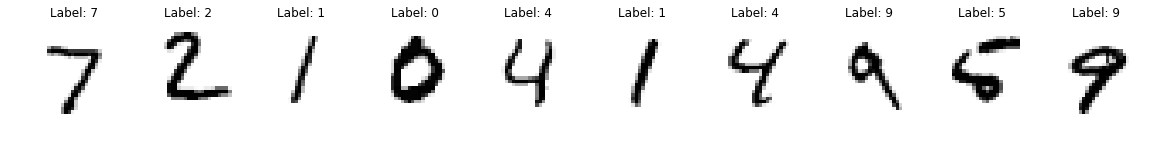

Decoder Output Images


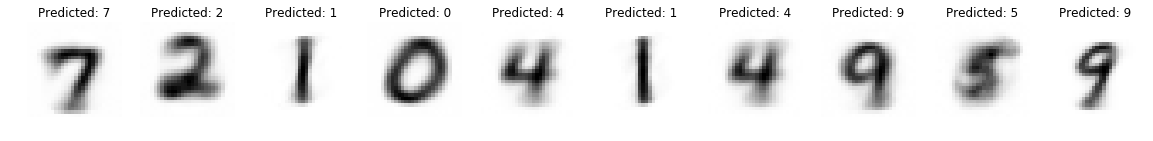

In [46]:
sample_images = sample_images.reshape([-1, 28, 28])
reconst_image = decoder_out_val.reshape([-1, 28,28])

print('Input Images')
plt.figure(figsize = (n_samples * 2, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(sample_images[i], cmap='binary')
    plt.title('Label: ' + str(y_test[i]))
    plt.axis('off')
    
plt.show()

print('Decoder Output Images')
plt.figure(figsize = (n_samples * 2, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.title('Predicted: ' + str(y_test[i]))
    plt.imshow(reconst_image[i], cmap='binary')
    plt.axis('off')

plt.show()